# Geopandas Shapefile Extraction

Utility notebook for loading a shapefile with **geopandas**, performing a simple inspection, and exporting data to a convenient format (e.g., CSV). This can be used as a starting point for any geospatial data preprocessing within the ETL pipeline.

In [ ]:
# Install geopandas in the current environment if needed
# !pixi add --feature gis --pypi geopandas
# (Uncomment the line above and run the cell in the appropriate environment)


In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
""
# Path to your shapefile (update this path to point at the desired .shp file)
#shapefile_path = 'data/example_shapefile.shp'

shapefile_path = '/Users/pjsmitty301/BioCirV/i15_crop_mapping_2023_provisional'

# Load the shapefile
gdf = gpd.read_file(shapefile_path)

# Quick inspection
print(gdf.head())
print(f'CRS: {gdf.crs}')


    DataStatus UniqueID DWR_REVISE SYMB_CLASS MULTIUSE CLASS1 SUBCLASS1  \
0  Provisional  4900289       None          G        S     **        **   
1  Provisional  4900338       None          G        S     **        **   
2  Provisional  4901032       None          G        S     **        **   
3  Provisional  4901050       None          G        S     **        **   
4  Provisional  4901182       None          G        D      V        **   

  SPECOND1 IRR_TYP1PA IRR_TYP1PB  ... REGION     ACRES  COUNTY    HYDRO_RGN  \
0        *          *          *  ...   NCRO  0.554073  Sonoma  North Coast   
1        *          *          *  ...   NCRO  3.381716  Sonoma  North Coast   
2        *          *          *  ...   NCRO  1.222060  Sonoma  North Coast   
3        *          *          *  ...   NCRO  1.247221  Sonoma  North Coast   
4        *          *          *  ...   NCRO  0.810619  Sonoma  North Coast   

            LIQ_REPORT MAIN_CROP MAIN_CROP_ Shape_Leng    Shape_Area  \
0 

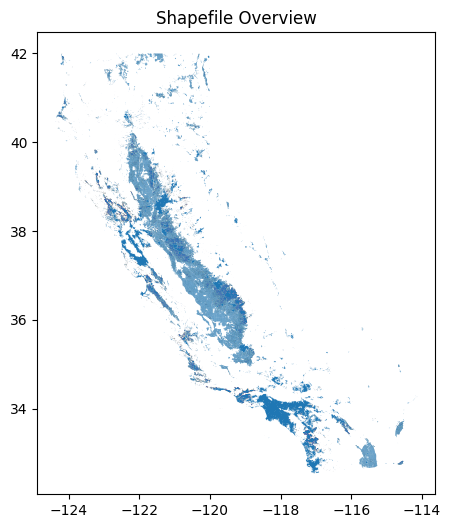

In [16]:
# Plot the geometry (simple quick visual)
gdf.plot(figsize=(10, 6))
plt.title('Shapefile Overview')
plt.show()


In [10]:
import os
import sys
import pandas as pd
import numpy as np
import janitor as jn
import logging
from IPython.display import display
from sqlalchemy.orm import Session
from sqlalchemy import select

# --- Basic Logging Configuration for Notebook ---
# When running in a notebook, we use Python's standard logging.
# In the production pipeline, this will be replaced by Prefect's `get_run_logger()`
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

# --- Robustly find the project root ---
# This ensures that the notebook can be run from any directory within the project.
path = os.getcwd()
project_root = None
while path != os.path.dirname(path):
    if 'pixi.toml' in os.listdir(path):
        project_root = path
        break
    path = os.path.dirname(path)

if not project_root:
    raise FileNotFoundError("Could not find project root containing 'pixi.toml'.")

# Add the project root to the Python path to allow for module imports
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    logger.info(f"Added project root '{project_root}' to sys.path")
else:
    logger.info(f"Project root '{project_root}' is already in sys.path")


2026-01-13 22:23:41,520 - INFO - Added project root '/Users/pjsmitty301/ca-biositing' to sys.path


In [12]:
# Use the refactored cleaning/coercion helpers from the new package
from src.ca_biositing.pipeline.ca_biositing.pipeline.utils.cleaning_functions import standard_clean, coerce_columns, coerce_columns_list

def clean_the_gsheets(df, lowercase=True, replace_empty=True):
    """Wrapper that applies the standardized cleaning pipeline implemented in `cleaning_functions`."""
    logger.info('Starting DataFrame cleaning via standard_clean.')
    if not isinstance(df, pd.DataFrame):
        logger.error('Input is not a pandas DataFrame.')
        return None
    try:
        # Run the composed standard clean (names, empty->NA, lowercase, convert_dtypes)
        df_cleaned = standard_clean(df, lowercase=lowercase, replace_empty=replace_empty)
        # Preserve behaviour: drop rows missing key columns if present
        subset = [c for c in ['resource', 'value'] if c in df_cleaned.columns]
        if subset:
            df_cleaned = df_cleaned.dropna(subset=subset)
        logger.info(f'Cleaning complete; rows remaining: {len(df_cleaned)}')
        return df_cleaned
    except Exception as e:
        logger.error(f'An error occurred during DataFrame cleaning: {e}', exc_info=True)
        return None


# --- Coercion Configuration Templates ---
# You can define column coercions in two ways: explicit keyword arguments or a dtype_map dictionary.
# For geometry: use geopandas to load shapefiles (geometry column is already properly typed).
# Only use geometry_cols if you have WKT strings to parse.

# APPROACH 1: Explicit keyword arguments (clear and direct)
COERCION_CONFIG_EXPLICIT = {
    'int_cols': ['repl_no', 'sample_no'],
    'float_cols': ['value', 'measurement'],
    'datetime_cols': ['created_at', 'updated_at'],
    'bool_cols': ['is_valid'],
    'category_cols': ['status'],
    'geometry_cols': []  # Use only if you have WKT strings; prefer geopandas for shapefiles
}

# APPROACH 2: dtype_map dictionary (compact, useful for dynamic configs)
COERCION_CONFIG_DTYPE_MAP = {
    'int': ['repl_no', 'sample_no'],
    'float': ['value', 'measurement'],
    'datetime': ['created_at', 'updated_at'],
    'bool': ['is_valid'],
    'category': ['status'],
    'geometry': []  # Use only if you have WKT strings; prefer geopandas for shapefiles
}

# APPROACH 3: GeoPandas GeoDataFrame (for shapefiles and spatial data)
# When loading shapefiles with geopandas, geometry is already a GeoSeries.
# Use geometry_format='geodataframe' to skip coercion:
GEOPANDAS_CONFIG = {
    'int_cols': ['id', 'repl_no'],
    'float_cols': ['area', 'value'],
    'geometry_cols': ['geometry'],
    'geometry_format': 'geodataframe'  # Don't convert; already properly typed
}

# Usage: coerce_the_gsheets(df, **COERCION_CONFIG_EXPLICIT)
#   or: coerce_the_gsheets(df, dtype_map=COERCION_CONFIG_DTYPE_MAP)
#   or: coerce_the_gsheets(gdf, **GEOPANDAS_CONFIG)  # for GeoDataFrames


def coerce_the_gsheets(df, dtype_map=None, int_cols=None, float_cols=None, datetime_cols=None, bool_cols=None, category_cols=None, geometry_cols=None, geometry_format='wkt'):
    """Coerce specified columns on a cleaned DataFrame using coercion helpers.
    `dtype_map` is an alternative mapping where keys are 'int','float','datetime','bool','category','geometry'.
    `geometry_format` controls geometry coercion: 'wkt' (parse WKT strings) or 'geodataframe' (skip, already typed)."""
    if not isinstance(df, pd.DataFrame):
        logger.error('coerce_the_gsheets: input is not a DataFrame')
        return df
    return coerce_columns(df, int_cols=int_cols, float_cols=float_cols, datetime_cols=datetime_cols, bool_cols=bool_cols, category_cols=category_cols, geometry_cols=geometry_cols, dtype_map=dtype_map, geometry_format=geometry_format)


In [14]:
clean_the_gsheets(gdf).dtypes

2026-01-13 22:26:13,899 - INFO - Starting DataFrame cleaning via standard_clean.
/Users/pjsmitty301/ca-biositing/src/ca_biositing/pipeline/ca_biositing/pipeline/utils/cleaning_functions/cleaning.py:40: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return df.astype("object").replace(regex, np.nan, regex=True)
2026-01-13 22:26:22,955 - INFO - Cleaning complete; rows remaining: 446713


datastatus    string[python]
uniqueid      string[python]
dwr_revise    string[python]
symb_class    string[python]
multiuse      string[python]
class1        string[python]
subclass1     string[python]
specond1      string[python]
irr_typ1pa    string[python]
irr_typ1pb    string[python]
pcnt1         string[python]
class2        string[python]
subclass2     string[python]
specond2      string[python]
irr_typ2pa    string[python]
irr_typ2pb    string[python]
pcnt2         string[python]
class3        string[python]
subclass3     string[python]
specond3      string[python]
irr_typ3pa    string[python]
irr_typ3pb    string[python]
pcnt3         string[python]
class4        string[python]
subclass4     string[python]
specond4      string[python]
irr_typ4pa    string[python]
irr_typ4pb    string[python]
pcnt4         string[python]
ucf_att       string[python]
yr_planted             Int64
sen_crop      string[python]
adoy_sen               Int64
croptyp1      string[python]
ctyp1_note    

In [5]:
# Export attributes to CSV for downstream processing (optional)
output_csv = 'data/shapefile_attributes.csv'
gdf.drop(columns='geometry').to_csv(output_csv, index=False)
print(f'Attributes exported to {output_csv}')


OSError: Cannot save file into a non-existent directory: 'data'